In [1]:
from deeplabv3.network.modeling import _segm_resnet

import torch
import os

import matplotlib.pyplot as plt
import numpy as np

from torchvision.transforms import PILToTensor
from utils import (
    read_data, 
    get_metadata,
    get_cell_annotations_in_tissue_coordinates,
    crop_and_upscale_tissue
)

tensor_transformation = PILToTensor()

In [40]:
model = _segm_resnet(name="deeplabv3plus", backbone_name="resnet50", num_classes=2, output_stride=8, pretrained_backbone=True)
model.eval()


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [46]:
from PIL import Image

im = Image.open("samples/1_image.png")

In [47]:
import torch
import numpy as np

image_arr = np.array(im).astype(np.float32).transpose((2, 0, 1))
tensor_image = torch.tensor(image_arr)
tensor_image = tensor_image.unsqueeze(0)

result = model(tensor_image)
print(f"result: {result}")

result: tensor([[[[ 73.4690,  73.4690,  84.1954,  ..., 104.8203, 103.3072, 103.3072],
          [ 73.4690,  73.4690,  84.1954,  ..., 104.8203, 103.3072, 103.3072],
          [ 75.1721,  75.1721,  83.6305,  ...,  95.5470,  94.3827,  94.3827],
          ...,
          [  0.3282,   0.3282,  -3.6419,  ...,  -2.0347,  -3.6127,  -3.6127],
          [ -3.2031,  -3.2031,  -7.8754,  ...,  -5.5667,  -7.2166,  -7.2166],
          [ -3.2031,  -3.2031,  -7.8754,  ...,  -5.5667,  -7.2166,  -7.2166]],

         [[125.4091, 125.4091, 124.5045,  ..., -30.2549, -27.3855, -27.3855],
          [125.4091, 125.4091, 124.5045,  ..., -30.2549, -27.3855, -27.3855],
          [112.4636, 112.4636, 111.4244,  ..., -38.9425, -36.1499, -36.1499],
          ...,
          [ 37.7299,  37.7299,  28.7570,  ..., -38.8837, -39.5934, -39.5934],
          [ 42.3353,  42.3353,  33.4688,  ..., -30.1762, -31.4464, -31.4464],
          [ 42.3353,  42.3353,  33.4688,  ..., -30.1762, -31.4464, -31.4464]]]],
       grad_fn=<Upsam

tensor([[[[2.7715e-23, 2.7715e-23, 3.1187e-18,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [2.7715e-23, 2.7715e-23, 3.1187e-18,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [6.3752e-17, 6.3752e-17, 8.4970e-13,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          ...,
          [5.7104e-17, 5.7104e-17, 8.4988e-15,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.6708e-20, 1.6708e-20, 1.1078e-18,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.6708e-20, 1.6708e-20, 1.1078e-18,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00]],

         [[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 9.9240

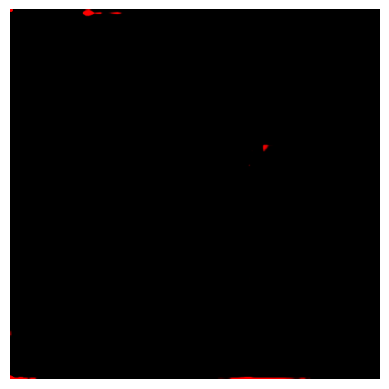

In [48]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Compute softmax scores
softmax_scores = F.softmax(result, dim=1)

# Get the scores for class 1
class_1_scores = softmax_scores[0, 1].detach().cpu().numpy()

print(softmax_scores)

# Create a color map based on the scores for class 1
# Higher scores will result in a more intense red color
color_map = np.zeros((class_1_scores.shape[0], class_1_scores.shape[1], 3))
color_map[:, :, 0] = class_1_scores * 255  # Red channel

# # Display the color-coded image
plt.imshow(color_map.astype(np.uint8))
plt.axis('off')  # Optionally remove the axes for better visualization
plt.show()


In [2]:
folder_path = "ocelot_data/"
metadata = get_metadata(folder_path)
data = read_data(folder_path)

Skipped file number 392 as the .csv was empty.
Skipped file number 217 as the .csv was empty.
Skipped file number 008 as the .csv was empty.
Skipped file number 042 as the .csv was empty.
Skipped file number 053 as the .csv was empty.
Skipped file number 570 as the .csv was empty.
Skipped file number 558 as the .csv was empty.


In [3]:
image_file_path = "ocelot_data/images/train/cell/"
segmentation_file_path = "ocelot_data/annotations/train/cell/"


image_files = [
    os.path.join(image_file_path, file_name)
    for file_name in os.listdir(image_file_path)
]
image_files.sort()

segmentation_files = [
    os.path.join(segmentation_file_path, file_name)
    for file_name in os.listdir(segmentation_file_path)
]
segmentation_files.sort()

In [5]:
import cv2

def create_cell_segmentation_image(
    annotated_data: torch.Tensor,
    cell_mpp: float,
    radius: float = 1.4,
    image_size: int = 1024,
):
    pixel_radius = int(radius / cell_mpp)
    image = np.zeros((image_size, image_size), dtype="uint8")

    for x, y, label in annotated_data:
        cv2.circle(
            image, (x.item(), y.item()), pixel_radius, label.item(), -1
        )  # -1 fills the circle
    return image


segmented_cell_folder = "ocelot_data/annotations/train/segmented_cell/"
os.makedirs(segmented_cell_folder, exist_ok=True)

for data_id, data_object in data.items():
    annotated_data = data_object["cell_annotated"]
    cell_mpp = data_object["cell_mpp"]

    segmented_cell_image = create_cell_segmentation_image(
        annotated_data=annotated_data, cell_mpp=cell_mpp
    )
    image_path = os.path.join(segmented_cell_folder, f"{data_id}.png")
    cv2.imwrite(image_path, segmented_cell_image)

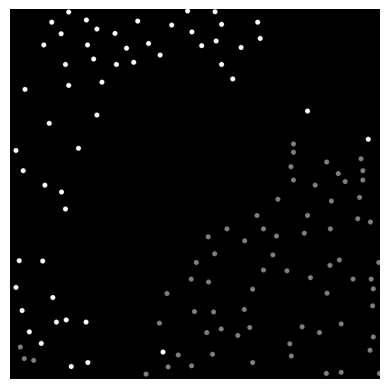

In [6]:
p = segmented_cell_folder + "288.png"
image = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.axis('off')  # Optional: Hide axes
plt.show()